In [5]:
pip install numpy trackpy pandas matplotlib pillow pims

     |████████████████████████████████| 92kB 4.4MB/s 
  Created wheel for pims: filename=PIMS-0.5-cp36-none-any.whl size=84328 sha256=7d543bd396afda2fbac76bc3289f67bb232c526bad3d55e82c7916c4f2f225f5
  Stored in directory: /root/.cache/pip/wheels/0e/0a/14/4c33a4cc1b9158e57329a38e8e3e03901ed24060eb322d5462
Successfully built pims


# Particle Tracking 

Authors : Clement Siegrist

I. Sequence one ParticleTracking01.tif

II. Sequence two Tracking_FITC.tif

III. DataAnalysis of Icy Sequence_stats.xls


In [2]:
from __future__ import division, unicode_literals, print_function
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
  # for compatibility with Python 2 and 3
import pims
import trackpy as tp
import glob
import matplotlib.pyplot as plt
from PIL import ImageSequence, Image
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

#I. Sequence One 


In [3]:
def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

def read_tiff_(path, n_images):
    """
        path - Path to the multipage-tiff file
        n_images - Number of pages in the tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            slice_ = np.zeros((img.height, img.width))
            for j in range(slice_.shape[0]):
                for k in range(slice_.shape[1]):
                    slice_[j, k] = img.getpixel((j, k))

            images.append(slice_)

        except EOFError:
            # Not enough frames in img
            break

    return np.array(images)

# Path towards the two sequences of particle store in tiff format
path_seq1 = '/content/ParticuleTracking01.tif'
path_seq2 = '/content/Tracking_FITC.tif'

frames = read_tiff(path_seq1)
#frames = frames.reshape(250, 321, 271)

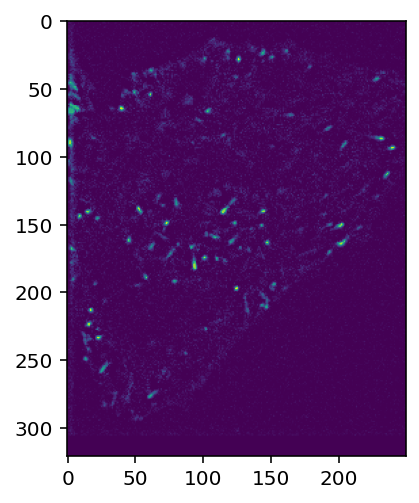

y           x      mass  ...    signal  raw_mass         ep
0  1.000000  154.000000  1.734809  ...  1.734809       8.0  -2.327362
1  2.000000   26.391892  2.852797  ...  1.734809       5.0  -1.770124
2  2.000000  223.000000  1.580604  ...  1.580604      17.0 -41.863473
3  2.602941   64.000000  2.621489  ...  1.580604       9.0  -2.600213
4  3.000000  121.402985  2.582938  ...  1.542052      13.0  -4.896308

[5 rows x 8 columns]

In [12]:
# locate returns a spreadsheet-like object called a DataFrame. It lists each feature's position,
# various characterizations of its appearance, which we will use to filter out spurious features,
# the "signal" strength and an estimate of uncertainty

f = tp.locate(frames[0], 3, invert=False)
plt.imshow(frames[0])
plt.show()
f.head()

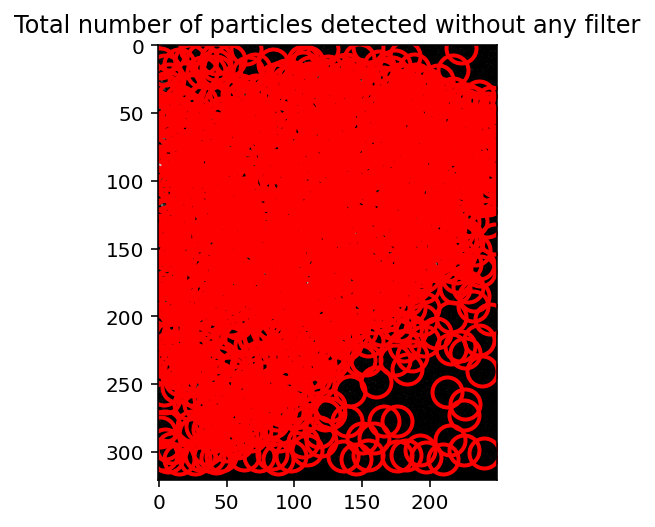

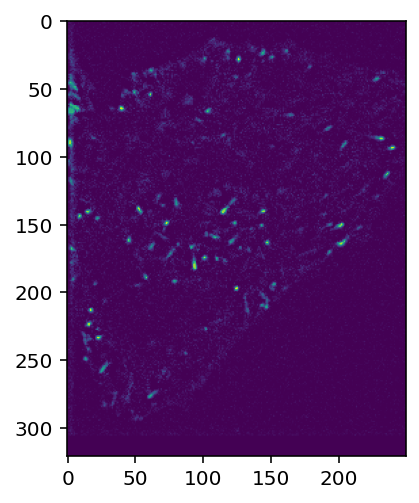

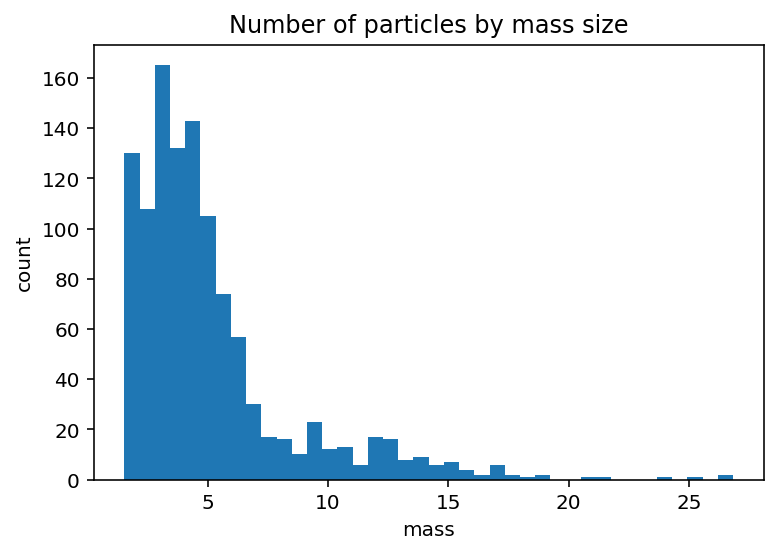

In [13]:
# with tp.annotate methods show how it suceeds in locating the particles on
# the first frame.

plt.title('Total number of particles detected without any filter')
tp.annotate(f, frames[0])
plt.imshow(frames[0])

fig, ax = plt.subplots()
plt.title('Number of particles by mass size')
ax.hist(f['mass'], bins=40)
ax.set(xlabel='mass', ylabel='count')
plt.show()


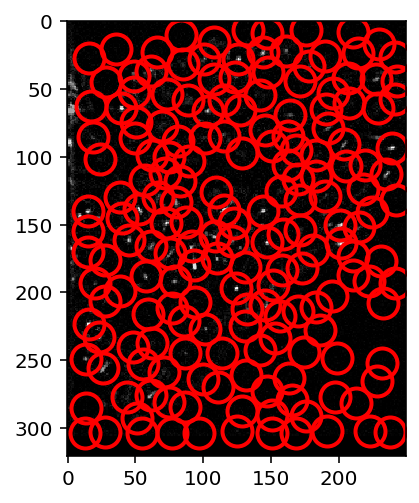

In [16]:
# Many of the previous detected particles are wrong 
# The most important way to dsitinguish bad particles 
# from good ones is to look at total brightness ("mass").

f = tp.locate(frames[0], 11, invert=False, minmass=40)
tp.annotate(f, frames[0])
plt.show()

Frame 270: 100 features


y           x        mass  ...  raw_mass        ep  frame
0  22.255058  166.353324  208.991963  ...   19946.0 -0.012893      0
1  24.002137  197.871795   70.670693  ...   20509.0 -0.063191      0
2  25.033417    8.167718  239.495126  ...   20192.0 -0.019768      0
3  24.887092  122.461770  551.019996  ...   18925.0 -0.005276      0
4  26.258319  146.368136  363.017832  ...   18669.0 -0.004596      0

[5 rows x 9 columns]

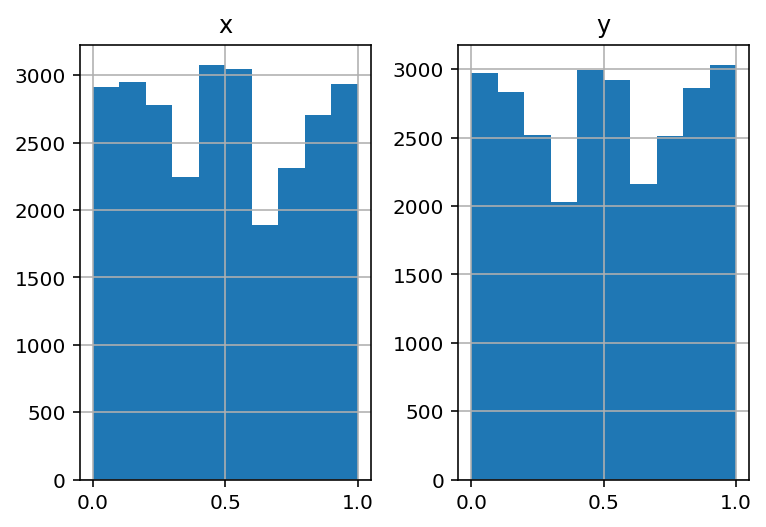

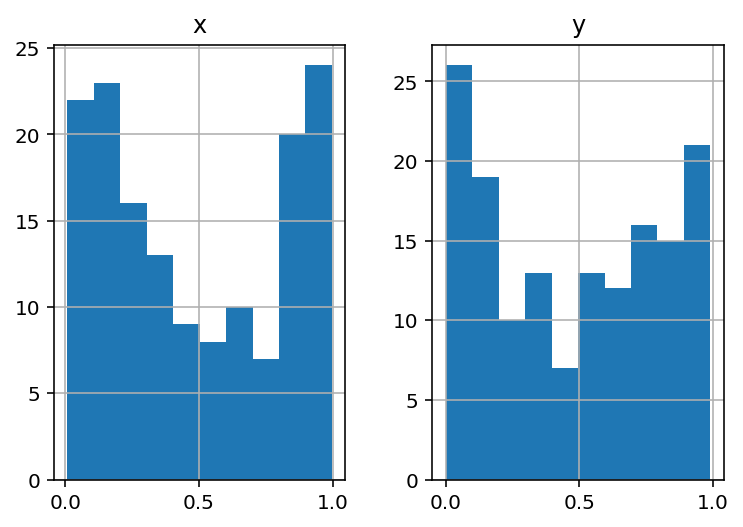

In [23]:
# Check for subpixel accuracy : a quick way to check for subpixel accuracy 
# is to check that the decimal part of the x and/or y positions are evenly distributed
# Trackpy provides a plotting function for this called subpx_bias:

tp.subpx_bias(f)
tp.subpx_bias(tp.locate(frames[0], 7, invert=True, minmass=40))

# We'll locate features in the first all the frames from this video. 
# We use tp.batch, which calls tp.locate on each frame and collects the results.
f = tp.batch(frames, 11, minmass=40, invert=True)

# shows the first few rows of data
f.head()  

Frame 270: 100 trajectories present.
Before: 6348
After: 1675


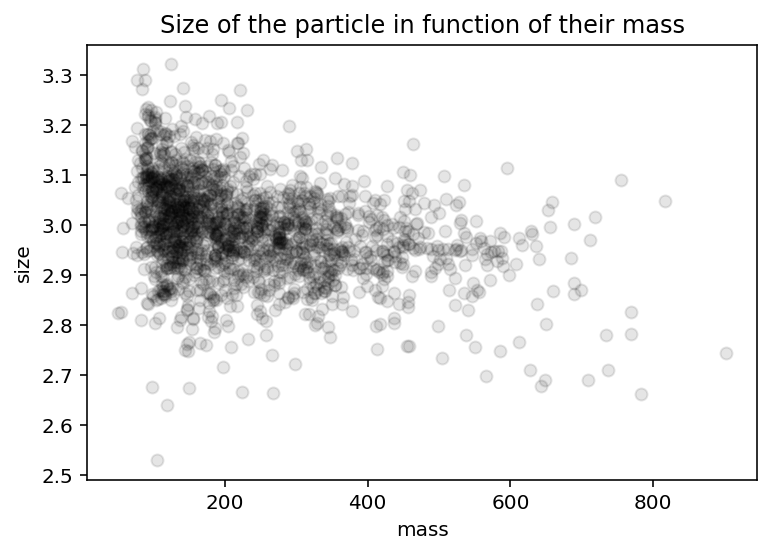

In [25]:
# we must must specify a maximum displacement, the farthest a particle can travel between frames. 
# We should choose the smallest reasonable value because a large value slows computation 
# time considerably. In this case, 5 pixels is reasonable.

# We allow for the possibility that a particle might be missed for a few frames 
# and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise 
# in the video.) Memory keeps track of disappeared particles and maintains their ID 
# for up to some number of frames after their last appearance. Here we use 1 frames
t = tp.link(f, 10, memory=1)

# Particle new column with label
t.head()
t1 = tp.filter_stubs(t, 5) ### Replace with 5

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())
plt.figure()
plt.title('Size of the particle in function of their mass')
tp.mass_size(t1.groupby('particle').mean())# convenience function -- just plots size vs. mass

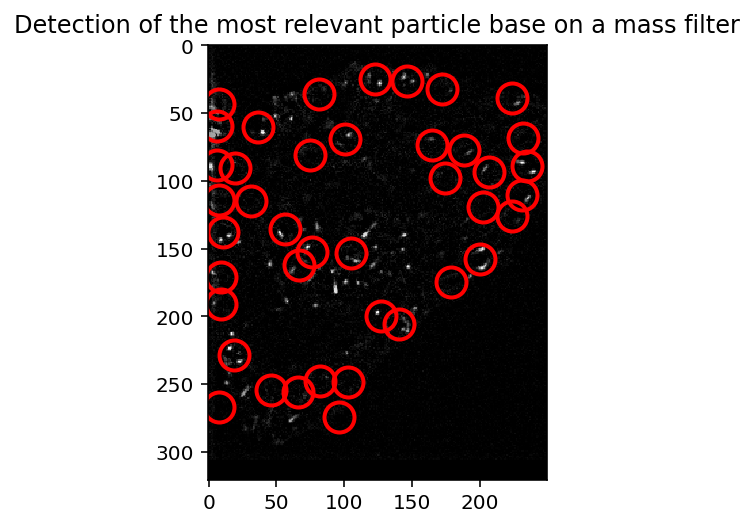

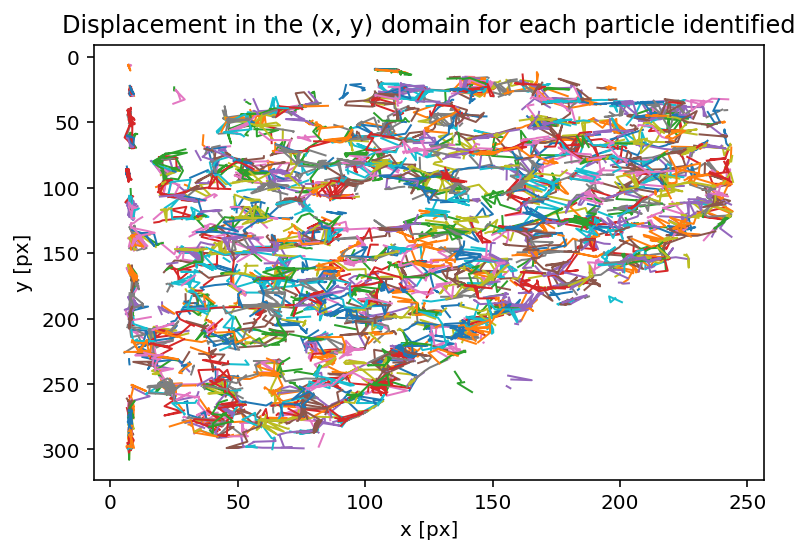

In [26]:
# The particles with especially low mass, or that are especially large or non-circular (eccentric), 
# are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, 
# filtering out regions of mass-size space and looking at the results using tp.annotate. 
# In the end, we need to separate the good particles from the spurious ones.

#t2 = t1[((t1['mass'] > 50) & (t1['size'] < 2.6) &
#         (t1['ecc'] < 0.3))]


t2 = t1[((t1['mass'] > 5))]
plt.figure()
plt.title('Detection of the most relevant particle base on a mass filter')
tp.annotate(t2[t2['frame'] == 0], frames[0])
plt.figure()
plt.title('Displacement in the (x, y) domain for each particle identified')
tp.plot_traj(t2)

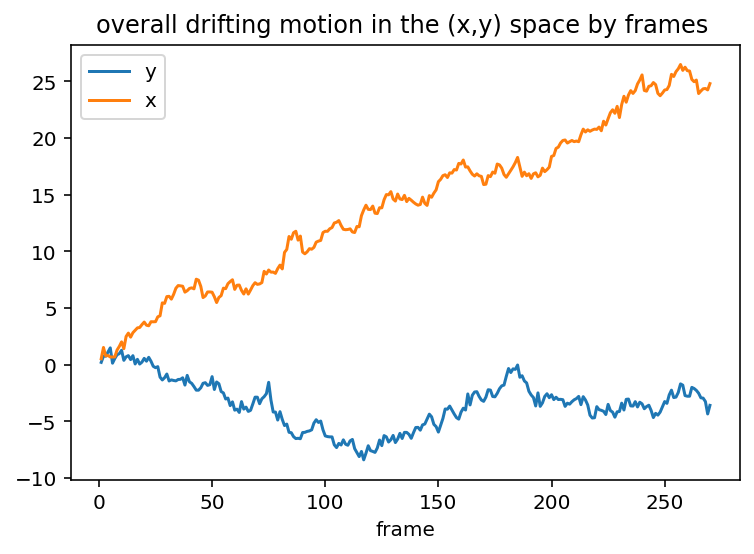

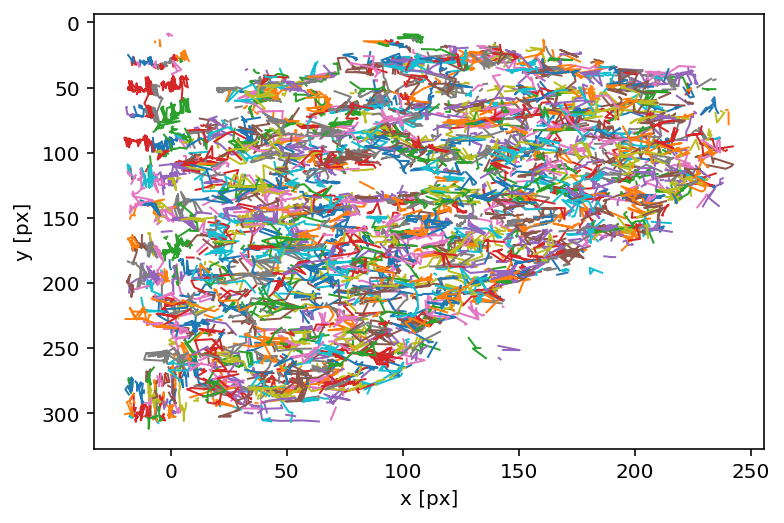

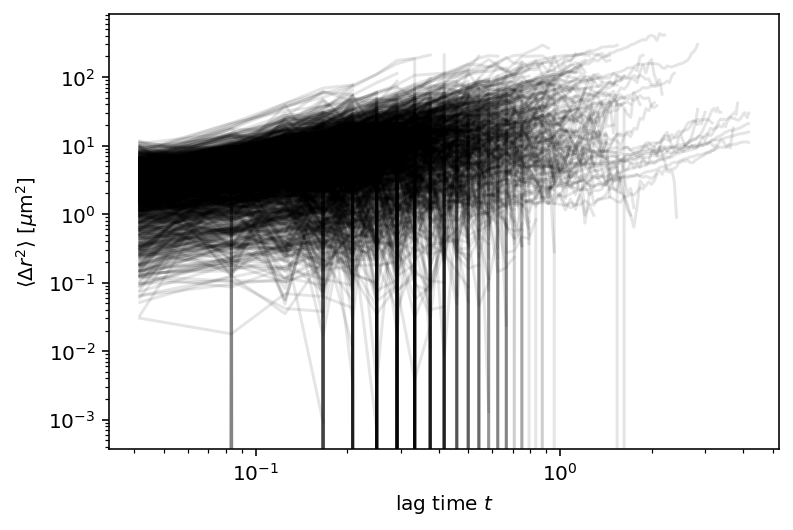

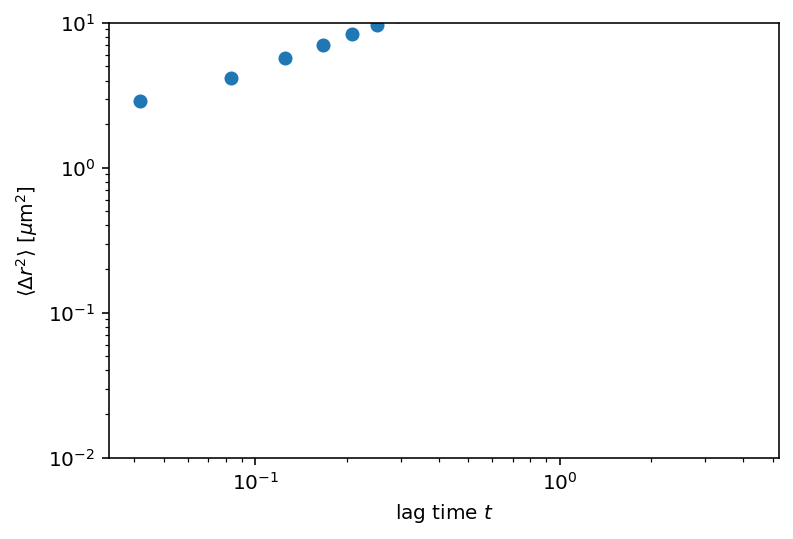

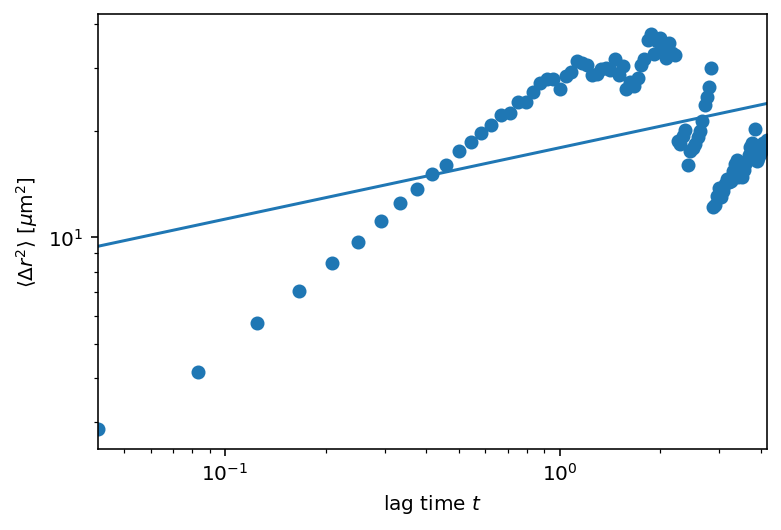

n          A
msd  0.202005  17.906272

In [28]:
# Remove overall drift
# Compute the overall drifting motion, which we will subtract away,
# adopting the reference frame of the particles' average position.

d = tp.compute_drift(t2)
d.plot()
plt.title('overall drifting motion in the (x,y) space by frames ')
plt.show()
tm = tp.subtract_drift(t2.copy(), d)

# Plot again with drift removed
ax = tp.plot_traj(tm)
plt.title('Displacement for each tracked particles with drift removed')
plt.show()

# Analyze Trajectories
# Compute Mean Squared Displacement
im = tp.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24

fig2, ax2 = plt.subplots()
ax2.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax2.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Mean square displacement in fonction of the time')
plt.show()

# Now use the emsd function to compute the ensemble mean squared displacement (EMSD) of all particles:
em = tp.emsd(tm, 100/285., 24) # microns per pixel = 100/285., frames per second = 24

fig3, ax3 = plt.subplots()
ax3.plot(em.index, em, 'o')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax3.set(ylim=(1e-2, 200))
ax3.set_title('Ensemble mean square displacement of all particles')
plt.show()

#We can easily fit this ensemble mean-squared displacement to a power law,
#$At^n$, using a convenience function, fit_powerlaw, which performs a linear regression in log space.

plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$')
plt.title('Ensemble mean square displacement of all particles power law reg')
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

In [18]:
# Stearming tpo PandaHDFS

with tp.PandasHDFStore('data.h5') as s:
    tp.batch(frames, 11, invert=True, minmass=200, output=s)

with tp.PandasHDFStore('data.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 3 frames
    for linked in tp.link_df_iter(s, 5, memory=3):
        s.put(linked)

with tp.PandasHDFStore('data.h5') as s:
    trajectories = pd.concat(iter(s))

## Parallelization

tp.batch(frames[:20], 11, invert=True, minmass=20, processes='auto')
tp.batch(frames[:20], 11, invert=True, minmass=20, engine='numba')
tp.batch(frames[:20], 11, invert=True, minmass=20, engine='python')

Frame 19: 91 features


y           x        mass  ...  raw_mass        ep  frame
0      22.255058  166.353324  208.991963  ...   19946.0 -0.012893      0
1      24.002137  197.871795   70.670693  ...   20509.0 -0.063191      0
2      25.033417    8.167718  239.495126  ...   20192.0 -0.019768      0
3      24.887092  122.461770  551.019996  ...   18925.0 -0.005276      0
4      26.258319  146.368136  363.017832  ...   18669.0 -0.004596      0
...          ...         ...         ...  ...       ...       ...    ...
1899  279.544586   22.291401   87.962856  ...   20514.0 -0.143290     19
1900  285.231803   80.000000  125.080940  ...   20486.0 -0.118642     19
1901  289.295066   51.861513  425.807456  ...   19672.0 -0.019772     19
1902  298.621053    7.387970   93.145381  ...   20542.0 -0.180862     19
1903  298.860515   71.178112   65.271801  ...   20552.0 -0.199550     19

[1904 rows x 9 columns]

# II. Sequence Two 


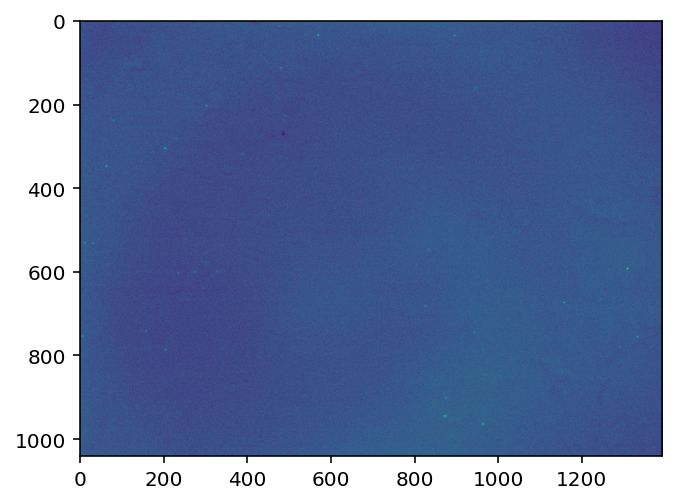

y          x      mass  ...    signal  raw_mass          ep
0  4.000000    7.60535  5.255511  ...  3.181424  326182.0   -1.071580
1  4.300732   53.00000  5.198693  ...  3.635279  326223.0    0.677482
2  4.338315   73.00000  4.470887  ...  2.958318  326175.0   -0.743750
3  4.000000  193.00000  2.244682  ...  2.244682  326198.0  142.939498
4  4.000000  207.00000  2.501685  ...  2.501685  326192.0   -2.893701

[5 rows x 8 columns]

In [30]:
# Locate returns a spreadsheet-like object called a DataFrame. It lists each feature's position,
# various characterizations of its appearance, which we will use to filter out spurious features,
# the "signal" strength and an estimate of uncertainty

frames2 = read_tiff(path_seq2)
f2 = tp.locate(frames2[1], 3, invert=True)
plt.imshow(frames2[1])
plt.show()
f2.head()

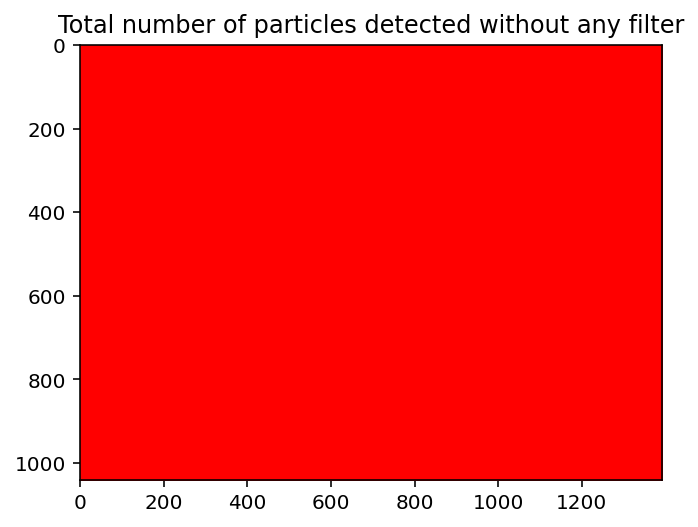

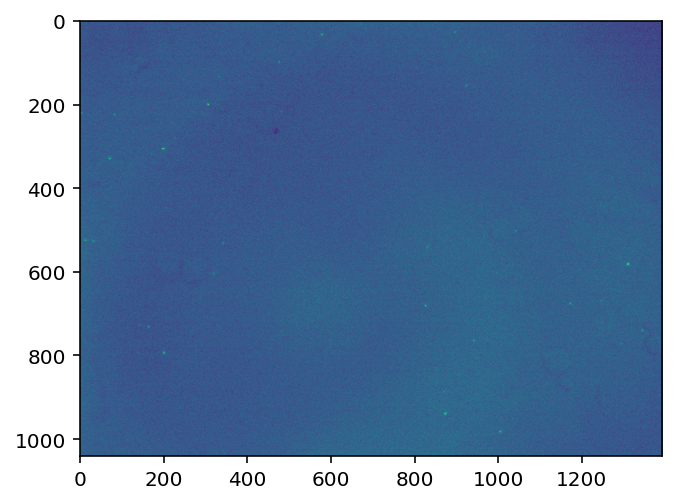

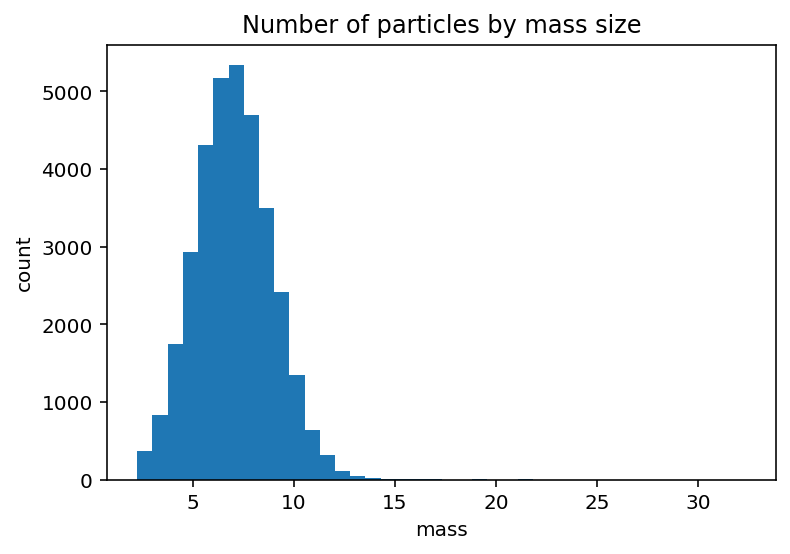

In [31]:
# with tp.annotate methods show how it suceeds in locating the particles on
# the first frame.

# It displays a completetly red screen, so as you can see tp.annotate 
# can't be used alone for data analysis

plt.title('Total number of particles detected without any filter')
tp.annotate(f2, frames2[0])
plt.imshow(frames2[0])

fig, ax = plt.subplots()
plt.title('Number of particles by mass size')
ax.hist(f2['mass'], bins=40)
ax.set(xlabel='mass', ylabel='count')
plt.show()

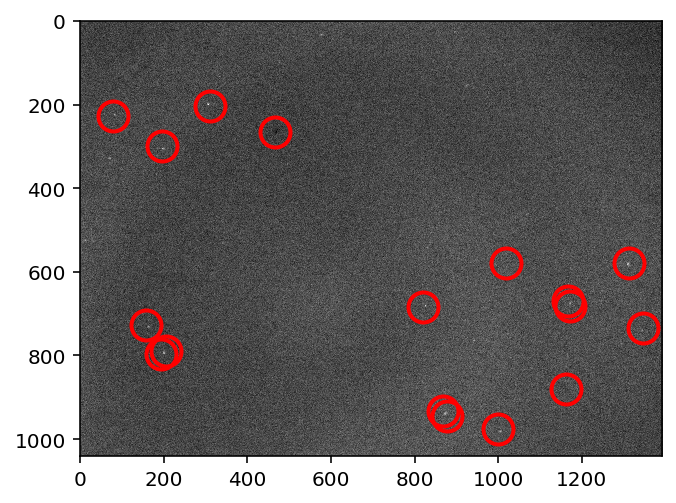

In [39]:
# Locate annotate and substract some pixel
# And filters the good from the bad ones with minmass
f2 = tp.locate(frames2[0], 11, invert=True, minmass=300)
tp.annotate(f2, frames2[0])

Frame 167: 266 features


y            x        mass  ...   raw_mass         ep  frame
0  203.615911   310.613087  412.031970  ...  5284342.0   0.675010      0
1  227.962881    79.619485  317.891675  ...  5283931.0  59.428389      0
2  265.976877   466.975039  468.275582  ...  5285916.0   0.141033      0
3  300.095005   195.574112  406.699115  ...  5283287.0  -0.438958      0
4  577.919953  1018.638403  305.794613  ...  5283907.0 -14.556246      0

[5 rows x 9 columns]

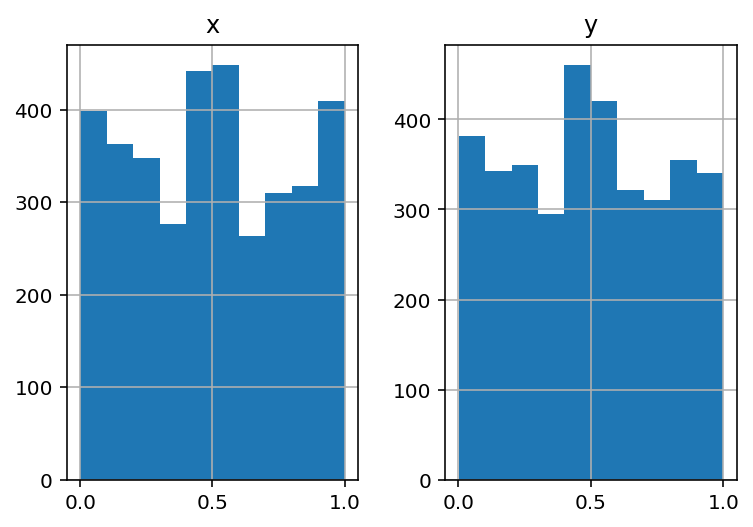

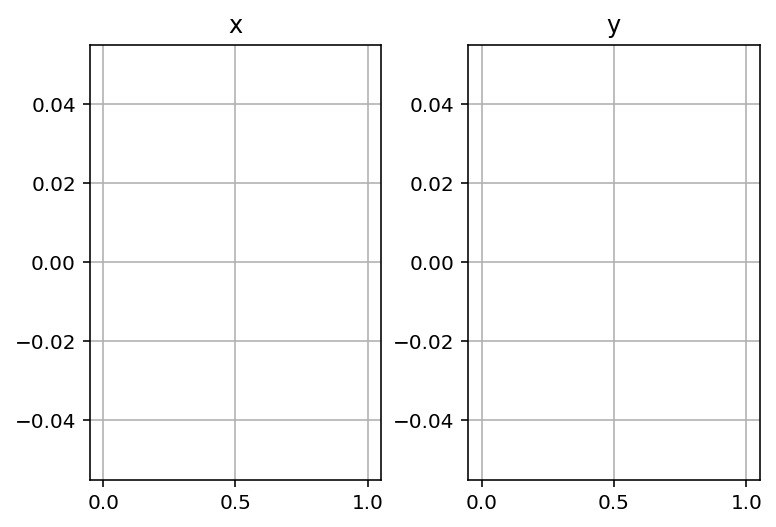

In [49]:
# Check for subpixel accuracy : a quick way to check for subpixel accuracy 
# is to check that the decimal part of the x and/or y positions are evenly distributed
# Trackpy provides a plotting function for this called subpx_bias:

tp.subpx_bias(f2)
tp.subpx_bias(tp.locate(frames2[0], 7, invert=True, minmass=300))
f2 = tp.batch(frames2, 11, minmass=300, invert=True)
f2.head()  # shows the first few rows of data


Frame 167: 266 trajectories present.
Before: 4656
After: 1054


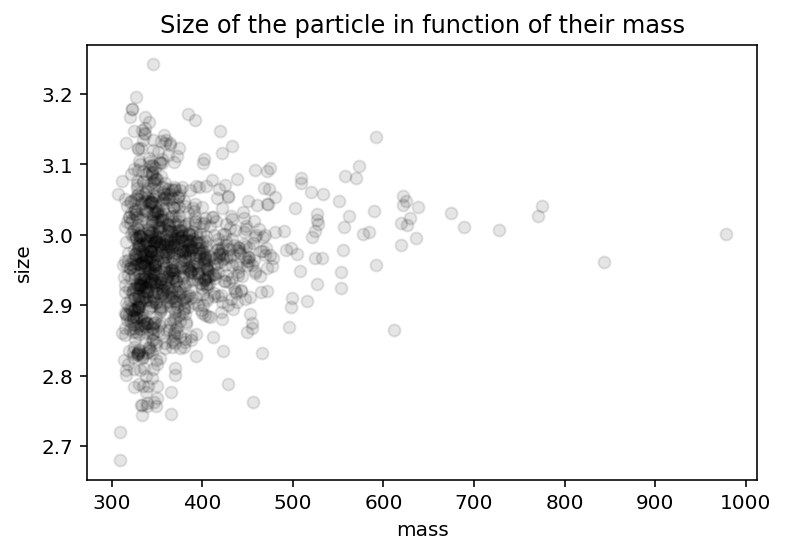

In [53]:
# we must must specify a maximum displacement, the farthest a particle can travel between frames. 
# We should choose the smallest reasonable value because a large value slows computation 
# time considerably. In this case, 5 pixels is reasonable.

# We allow for the possibility that a particle might be missed for a few frames 
# and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise 
# in the video.) Memory keeps track of disappeared particles and maintains their ID 
# for up to some number of frames after their last appearance. Here we use 3 frames
t2 = tp.link(f2, 20, memory=6)

# Particle new column with label
t2.head()
t3 = tp.filter_stubs(t2, 5) ### Replace with 5

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t2['particle'].nunique())
print('After:', t3['particle'].nunique())
plt.figure()
plt.title('Size of the particle in function of their mass')
tp.mass_size(t3.groupby('particle').mean())# convenience function -- just plots size vs. mass

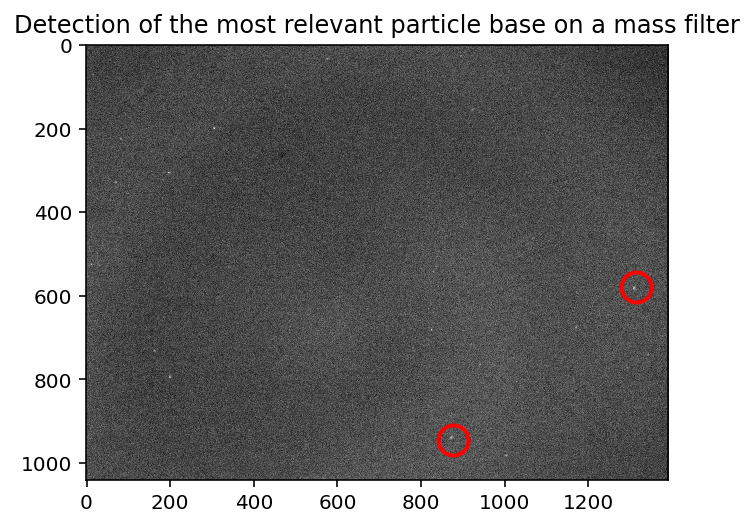

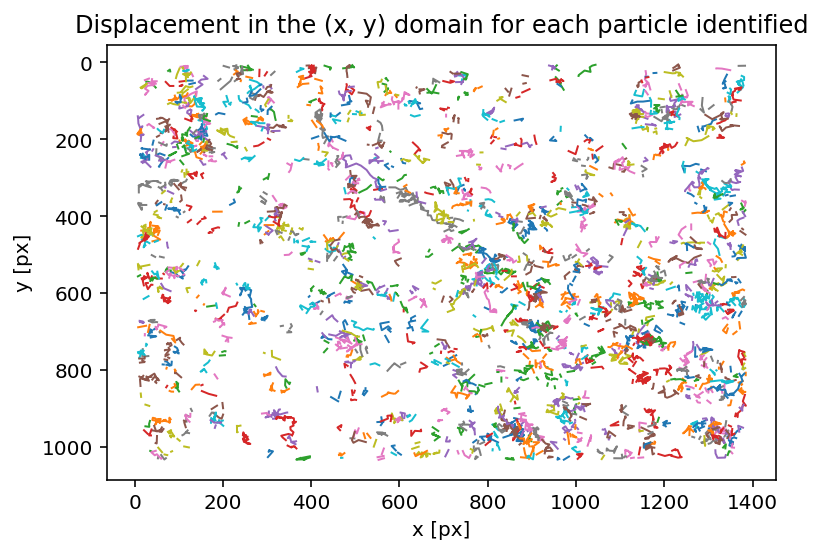

In [54]:
# The particles with especially low mass, or that are especially large or non-circular (eccentric), 
# are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, 
# filtering out regions of mass-size space and looking at the results using tp.annotate. 
# In the end, we need to separate the good particles from the spurious ones.

#t2 = t1[((t1['mass'] > 50) & (t1['size'] < 2.6) &
#         (t1['ecc'] < 0.3))]


t4 = t3[((t3['mass'] > 0))]
plt.figure()
plt.title('Detection of the most relevant particle base on a mass filter')
tp.annotate(t4[t4['frame'] == 0], frames2[0])
plt.figure()
plt.title('Displacement in the (x, y) domain for each particle identified')
tp.plot_traj(t4)

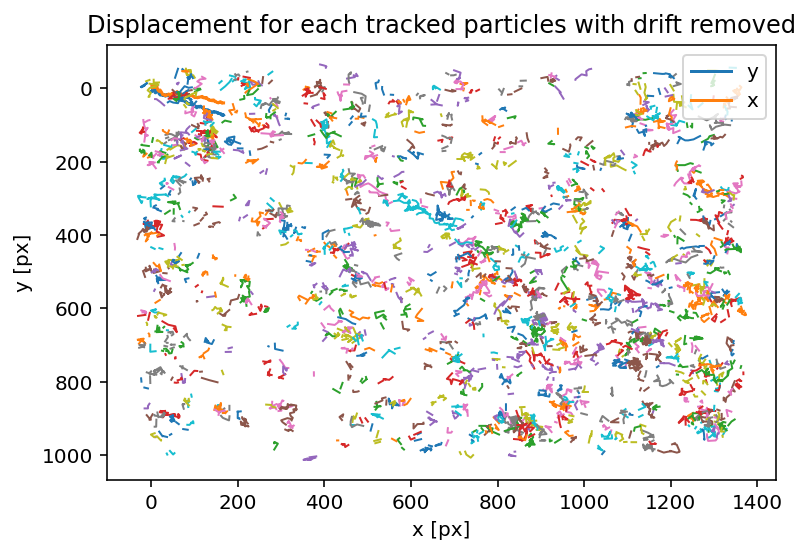

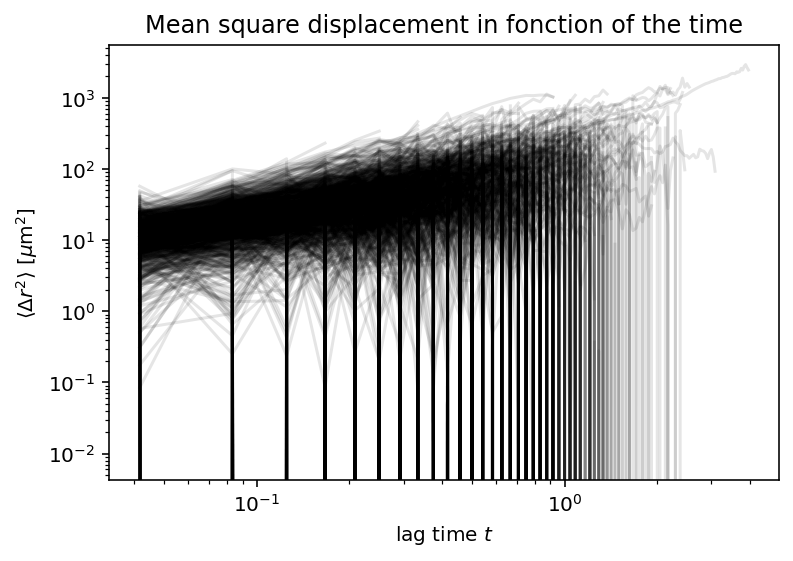

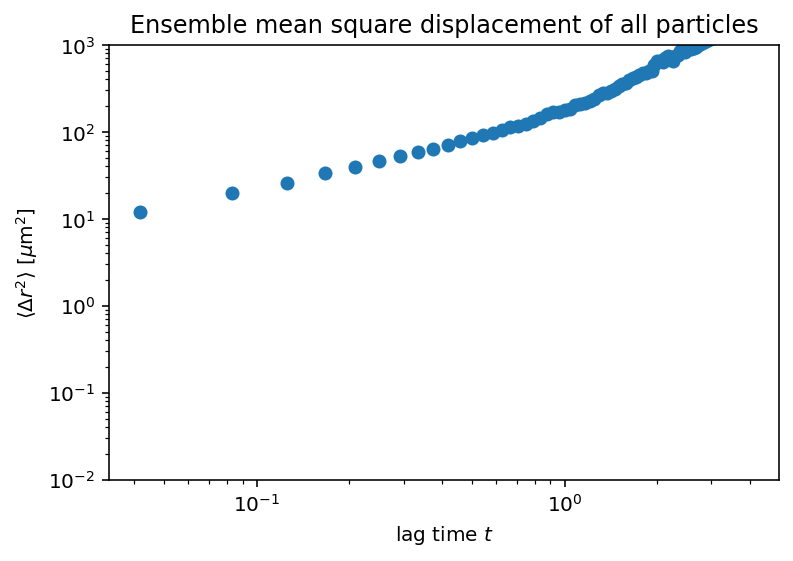

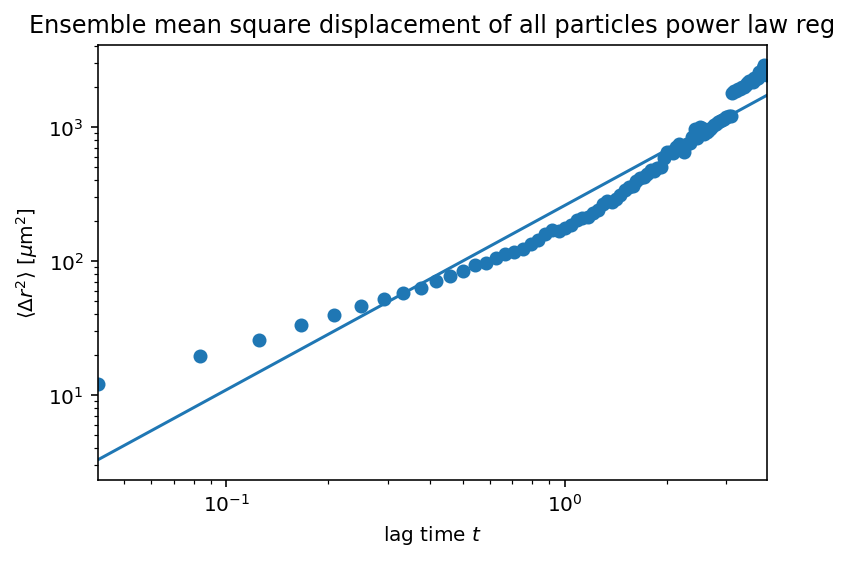

n           A
msd  1.377069  260.756186

In [61]:
# Remove overall drift
# Compute the overall drifting motion, which we will subtract away,
# adopting the reference frame of the particles' average position.

d2 = tp.compute_drift(t4)
d2.plot()
plt.title('overall drifting motion in the (x,y) space by frames ')
tm2 = tp.subtract_drift(t4.copy(), d2)

# Plot again with drift removed
plt.title('Displacement for each tracked particles with drift removed')
ax = tp.plot_traj(tm2)

# Analyze Trajectories
# Compute Mean Squared Displacement

im2 = tp.imsd(tm2, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24

fig2, ax2 = plt.subplots()
ax2.plot(im2.index, im2, 'k-', alpha=0.1)  # black lines, semitransparent
ax2.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Mean square displacement in fonction of the time')
plt.show()


# Now use the emsd function to compute the ensemble mean squared displacement (EMSD) of all particles:

em2 = tp.emsd(tm2, 100/285., 24) # microns per pixel = 100/285., frames per second = 24

fig3, ax3 = plt.subplots()
ax3.plot(em2.index, em2, 'o')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax3.set(ylim=(1e-2, 1000))
ax3.set_title('Ensemble mean square displacement of all particles')
plt.show()

#We can easily fit this ensemble mean-squared displacement to a power law,
#$At^n$, using a convenience function, fit_powerlaw, which performs a linear regression in log space.

plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$')
plt.title('Ensemble mean square displacement of all particles power law reg')
tp.utils.fit_powerlaw(em2)  # performs linear best fit in log space, plots]

In [62]:
# Stearming tpo PandaHDFS

with tp.PandasHDFStore('data_seq2.h5') as s:
    tp.batch(frames2, 11, invert=True, minmass=200, output=s)

with tp.PandasHDFStore('data_seq2.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 3 frames
    for linked in tp.link_df_iter(s, 5, memory=3):
        s.put(linked)

with tp.PandasHDFStore('data_seq2.h5') as s:
    trajectories_ = pd.concat(iter(s))

## Parallelization

tp.batch(frames[:20], 11, invert=True, minmass=20, processes='auto')
tp.batch(frames[:20], 11, invert=True, minmass=20, engine='numba')
tp.batch(frames[:20], 11, invert=True, minmass=20, engine='python')

Frame 19: 91 features


y           x        mass  ...  raw_mass        ep  frame
0      22.255058  166.353324  208.991963  ...   19946.0 -0.012893      0
1      24.002137  197.871795   70.670693  ...   20509.0 -0.063191      0
2      25.033417    8.167718  239.495126  ...   20192.0 -0.019768      0
3      24.887092  122.461770  551.019996  ...   18925.0 -0.005276      0
4      26.258319  146.368136  363.017832  ...   18669.0 -0.004596      0
...          ...         ...         ...  ...       ...       ...    ...
1899  279.544586   22.291401   87.962856  ...   20514.0 -0.143290     19
1900  285.231803   80.000000  125.080940  ...   20486.0 -0.118642     19
1901  289.295066   51.861513  425.807456  ...   19672.0 -0.019772     19
1902  298.621053    7.387970   93.145381  ...   20542.0 -0.180862     19
1903  298.860515   71.178112   65.271801  ...   20552.0 -0.199550     19

[1904 rows x 9 columns]

III. Data Analysis of the Icy xlms file of the videos sequences

In [4]:
icy_seq1 = pd.read_excel('/Speed_particle.xls')
icy_seq2 = ''

print(icy_seq1.head())
print(icy_seq1.columns)

            Group  Track #  ...  Max. disp. (px)  Avg. disp. (px)
0  mhtTracks-Run1        0  ...         5.011860         1.115975
1  mhtTracks-Run1        1  ...         0.543984         0.400839
2  mhtTracks-Run1        2  ...         2.167871         0.854695
3  mhtTracks-Run1        3  ...         2.508969         0.781221
4  mhtTracks-Run1        4  ...         1.207757         0.532020

[5 rows x 12 columns]
Index(['Group', 'Track #', 'Start (frames)', 'End (frames)',
       'Duration (frames)', 'Total disp. (px)', 'Net disp. (px)',
       'Linearity (%)', 'Search radius (px)', 'Min. disp. (px)',
       'Max. disp. (px)', 'Avg. disp. (px)'],
      dtype='object')


In [13]:
# Total average displacements
avg_dis = icy_seq1['Avg. disp. (px)'].mean()
print('Mean total average displacement is', avg_dis)

# We group by frames and sum the average total displacement for each frame
# in order to better understand the global dynamic of all particles in function of the time
print('------------------------------------------------------------------------')
track_stats = icy_seq1.groupby(["Start (frames)"])['Avg. disp. (px)'].count()
track_stats = track_stats[1:]
print('mean of the total average displacement', track_stats.mean())
print('------------------------------------------------------------------------')
print(track_stats)

Mean total average displacement is 1.262276752353468
------------------------------------------------------------------------
mean of the total average displacement 8.52
------------------------------------------------------------------------
Start (frames)
1      18
2      14
3      15
4      10
5       7
       ..
121    12
122     5
123    13
124     3
125     5
Name: Avg. disp. (px), Length: 125, dtype: int64


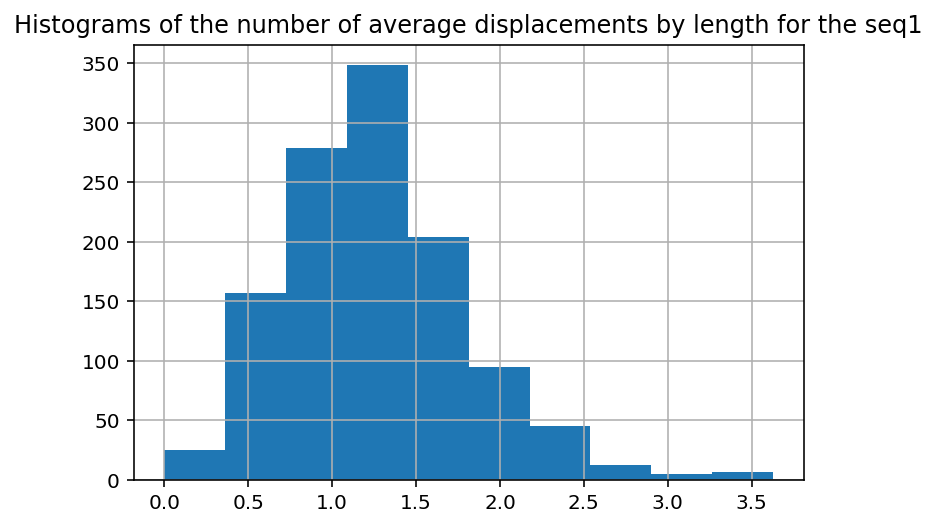

In [14]:
icy_seq1['Avg. disp. (px)'].hist()
plt.title('Histograms of the number of average displacements by length for the seq1')
plt.show()

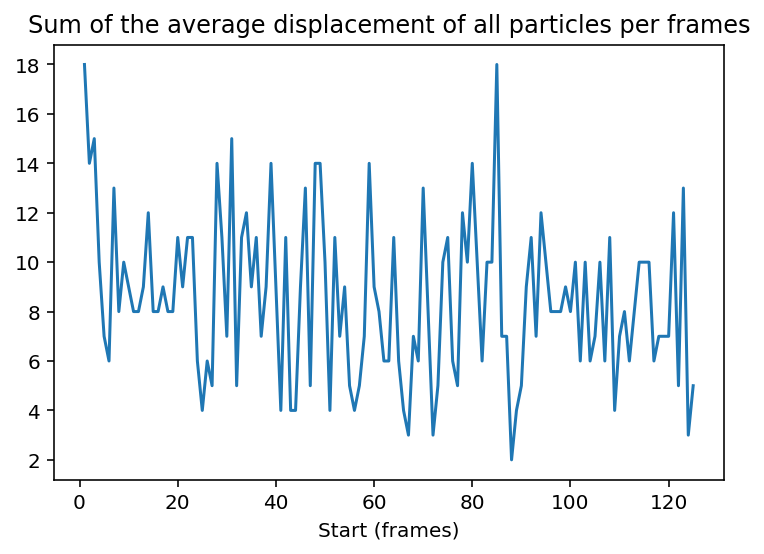

In [15]:
track_stats.describe()
track_stats.plot()
plt.title('Sum of the average displacement of all particles per frames')
plt.show()

First histogram : 